### **Machine Learning Star Classification**
Classification of stars based on their spectral characteristics

**Authors:**
- *Stefano Quaggio 866504*
- *Stefano Andreotti 851596*
- *Alberto Varisco 866109*

**Classification models used:**
- <u>Neaural Networks</u>
- <u>SVM</u>
- <u>K-Means Algorithm</u>

In [25]:
# All libraries imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#### <u>Neural Networks</u>

In [26]:
full_df = pd.read_csv('../dataset/star_classification.csv')
full_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [27]:
full_df.info()
# Check number of missing values in columns
full_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

array([[<AxesSubplot: title={'center': 'obj_ID'}>,
        <AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'delta'}>,
        <AxesSubplot: title={'center': 'u'}>],
       [<AxesSubplot: title={'center': 'g'}>,
        <AxesSubplot: title={'center': 'r'}>,
        <AxesSubplot: title={'center': 'i'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'run_ID'}>,
        <AxesSubplot: title={'center': 'rerun_ID'}>,
        <AxesSubplot: title={'center': 'cam_col'}>,
        <AxesSubplot: title={'center': 'field_ID'}>],
       [<AxesSubplot: title={'center': 'spec_obj_ID'}>,
        <AxesSubplot: title={'center': 'redshift'}>,
        <AxesSubplot: title={'center': 'plate'}>,
        <AxesSubplot: title={'center': 'MJD'}>],
       [<AxesSubplot: title={'center': 'fiber_ID'}>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

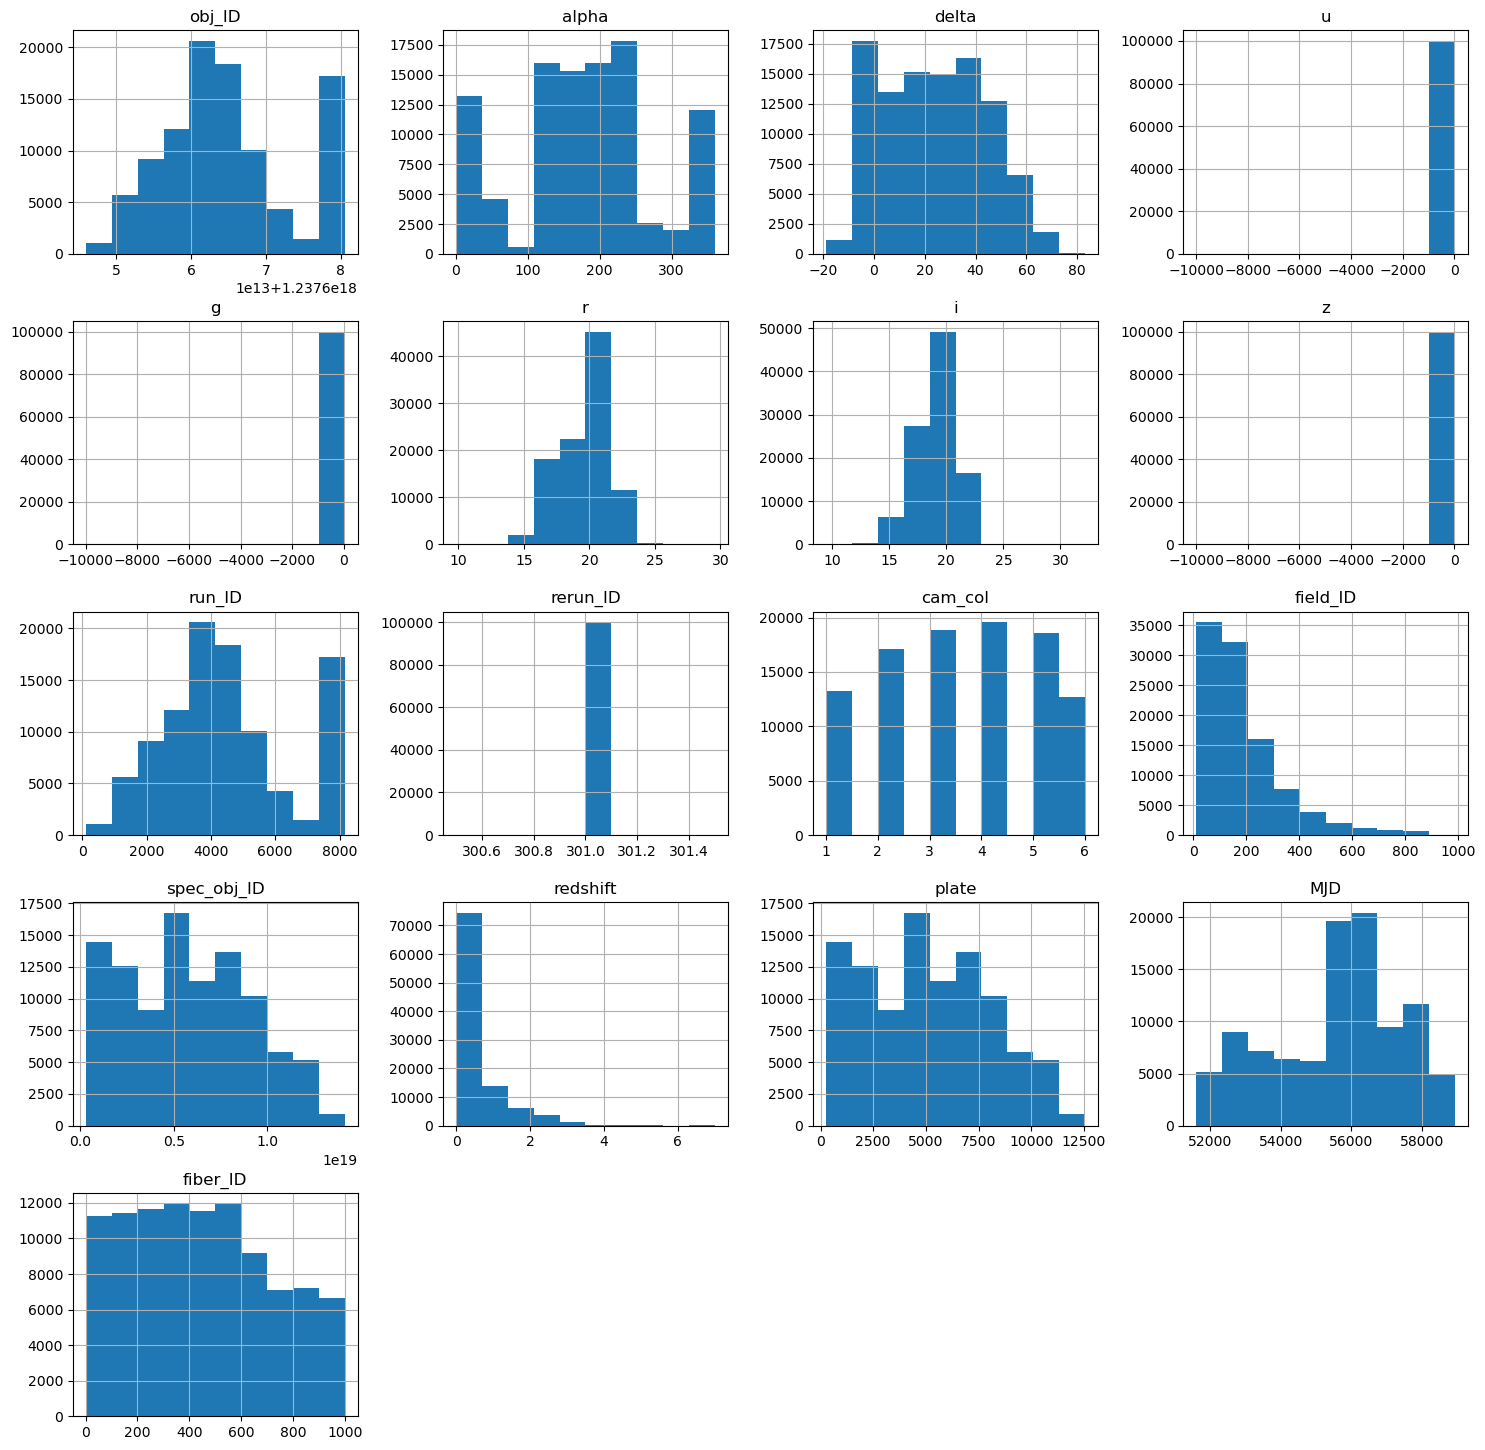

In [28]:
full_df.hist(figsize=(18,18))

<AxesSubplot: >

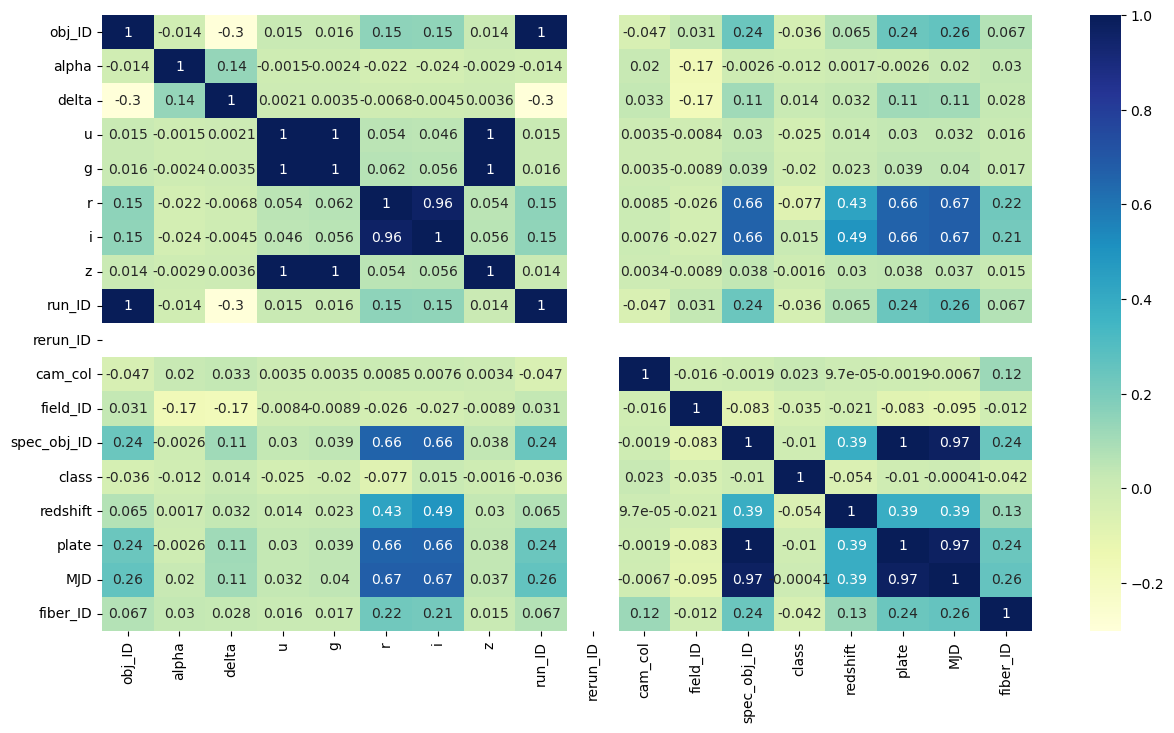

In [29]:
# Initialize LabelEncoder object
label_encoder = LabelEncoder()

# Apply LabelEncoder on 'class' column (target)
full_df['class'] = label_encoder.fit_transform(full_df['class'])
plt.figure(figsize=(15,8))
sns.heatmap(full_df.corr(), annot=True, cmap='YlGnBu')

In [30]:
# Remove 'rerun_ID' column as it has only one value and is not useful for classification
full_df.drop(['rerun_ID'], axis=1, inplace=True)
full_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,2,79,6.543777e+18,0,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,5,119,1.176014e+19,0,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,2,120,5.152200e+18,0,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,3,214,1.030107e+19,0,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,3,137,6.891865e+18,0,0.116123,6121,56187,842
